In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from environment import Environment
train_size = 1
test_size = 100

In [2]:
def generate_training_data(num_samples):
    X_train = np.linspace(-1, 1, num_samples).reshape(-1, 1)
    y_train = np.random.random(num_samples) * 0.9 + 0.1
    return X_train, y_train

# Параметры
num_models = train_size  + test_size  # Количество моделей ГП
num_samples = 10  # Количество обучающих данных для каждой модели

# Списки для хранения моделей и функций предсказания
gp_models = []
prediction_functions = []
envs = []
observes = []

# Генерация и обучение нескольких моделей ГП
for _ in range(num_models):
    X_train, y_train = generate_training_data(num_samples)
    
    # Определение ядра
    kernel = RBF(length_scale=3)
    
    # Создание и обучение модели гауссовского процесса
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)
    gp.fit(X_train, y_train)
    
    # Сохранение модели в список
    gp_models.append(gp)
    
    # Определение функции предсказания
    def prediction_function(x, model=gp):
        x = np.array(x).reshape(-1, 1)  # Преобразование x в нужный формат
        y_pred, _ = model.predict(x, return_std=True)
        if(y_pred.flatten().shape[0] == 1):
            return y_pred.flatten()[0]
        return y_pred.flatten()  # Возвращаем предсказания в одномерном виде
    
    prediction_functions.append(prediction_function)

    l_bounds = [-1,]
    u_bounds = [1,]
    env = Environment(X = np.array([[-1]]*10),y = prediction_function(np.array([[-1]]*10)),l_bounds = l_bounds,u_bounds = u_bounds, func = prediction_function, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1})
    observes.append(env.reset())
    envs.append(env)

In [4]:
train_functions_gauss = prediction_functions[:train_size]
test_functions_gauss = prediction_functions[train_size:]

In [11]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        #self.env = 'Pendulum-v0'
        self.hidden1 = 32
        self.hidden2 = 32
        self.rate =0.0001
        self.prate =0.0001
        self.warmup =100
        self.discount=0.99
        self.bsize=128
        self.rmsize=5000
        self.window_length=1
        self.tau = 0.1
        self.ou_theta =0.15
        self.ou_sigma=0.5
        self.ou_mu=0.0
        self.validate_episodes=50
        self.max_episode_length=30
        self.validate_steps=10000000
        self.output='output'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=10000
        self.epsilon=3000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

if args.seed > 0:
    np.random.seed(args.seed)

nb_states = envs[0].observation_space.shape[0]
nb_actions = envs[0].action_space.shape[0]

In [13]:
from ddpg_fol.ddpg import DDPG
from ddpg_fol.util import *
from ddpg_fol.evaluator import Evaluator
evaluate = Evaluator(args.validate_episodes, args.validate_steps, args.output, max_episode_length=30)#args.max_episode_length)
agent = DDPG(nb_states, nb_actions, args)

In [15]:
res = []
def train():
    num_steps =  np.zeros(train_size)
    agent.is_training = True
    step = episode = episode_steps = 0
    num_iterations = 10000
    while step < num_iterations: 
        idx = random.sample(range(train_size), 1)[0]
        env = envs[idx]
        obs = observes[idx]
        num_step = num_steps[idx]

        if episode <= args.warmup:
            action = agent.random_action()
        else:
            action = agent.select_action(obs)
            
        observation_new, reward, done, info = env.step(action)
        observes[idx] = deepcopy(observation_new)

        if num_step > 5:
            agent.observe(obs, action, reward, done)

        if episode > 5 and num_step >=9: 
            agent.update_policy()
     
        if step % int(num_iterations/3) == 0:
            agent.save_model(args.output)

        num_steps[idx] = num_step + 1
        
        if done or info: 
            res.append(reward)
            #env.toy_Plot(np.linspace(-1,1,20))

            observes[idx] = deepcopy(env.reset())
            num_steps[idx] =0
            episode += 1
        num_iterations-=1
    print(episode)

train()

KeyboardInterrupt: 

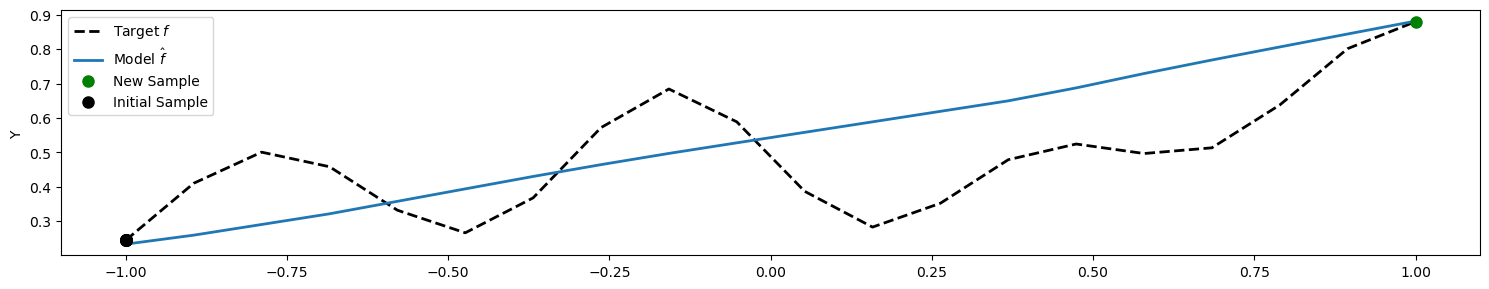

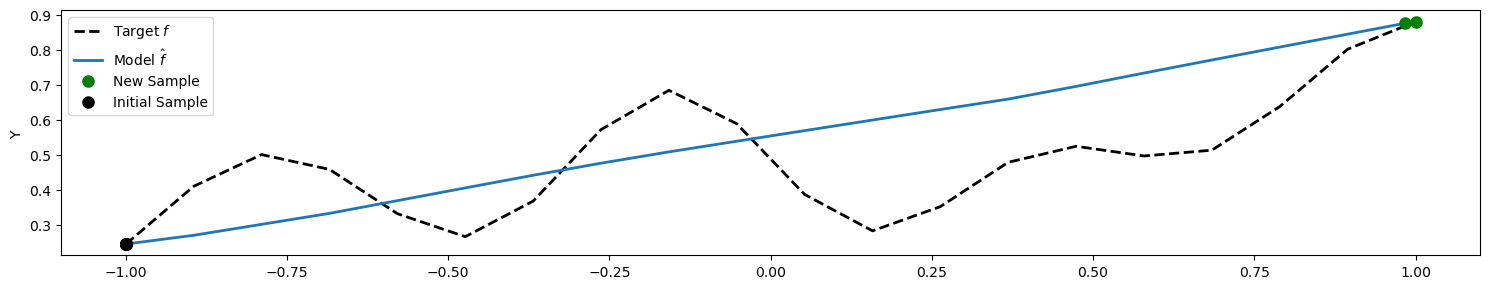

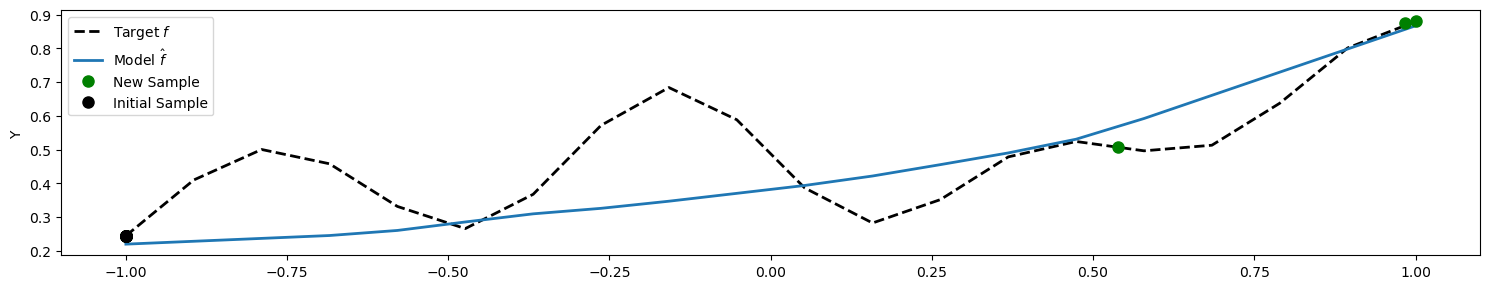

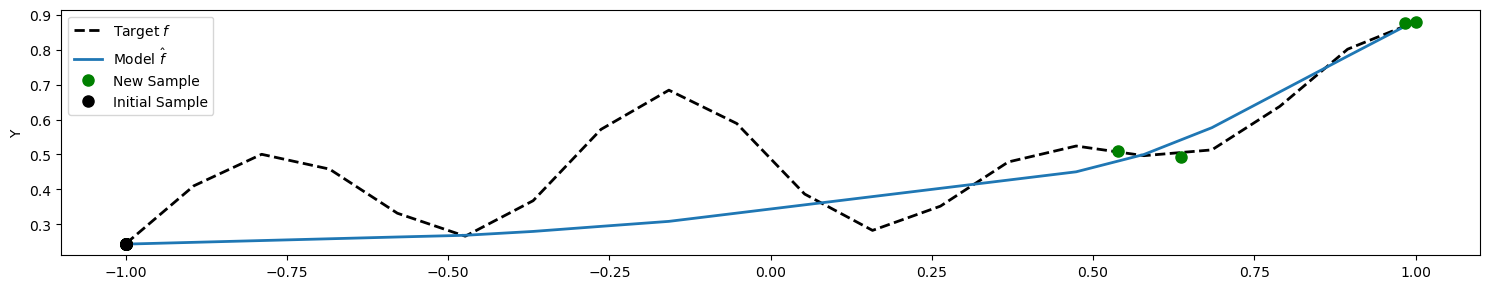

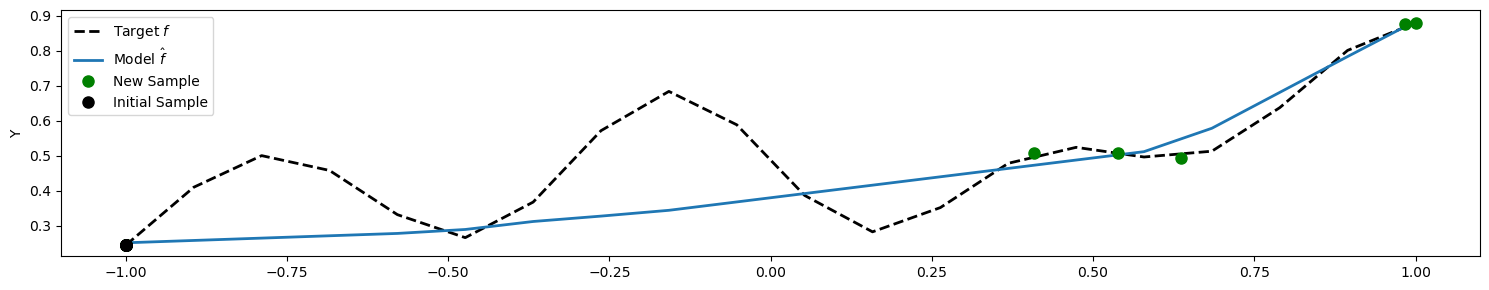

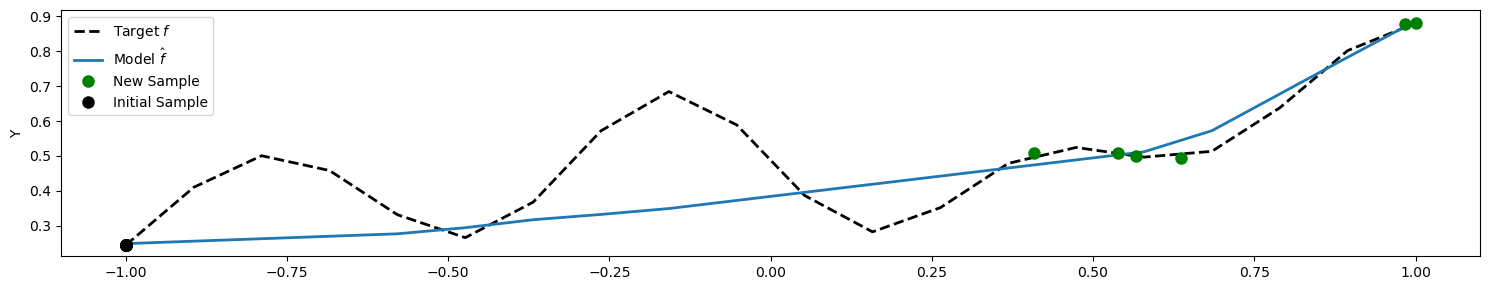

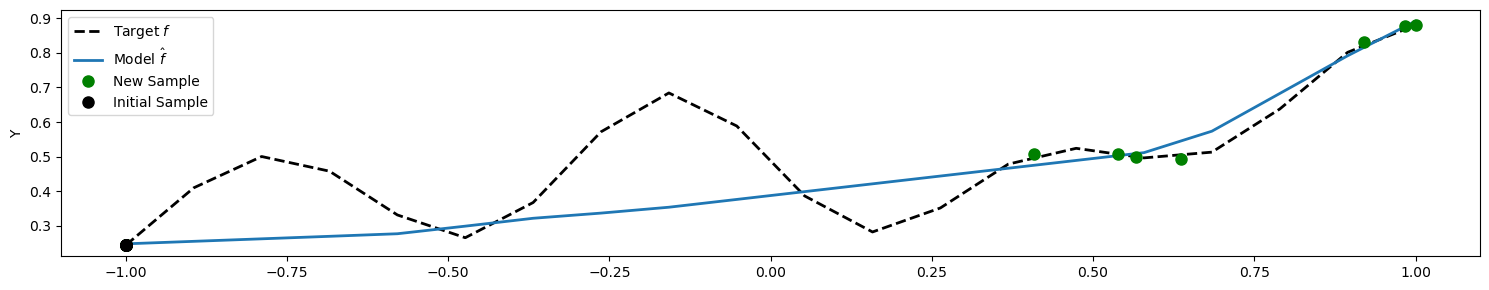

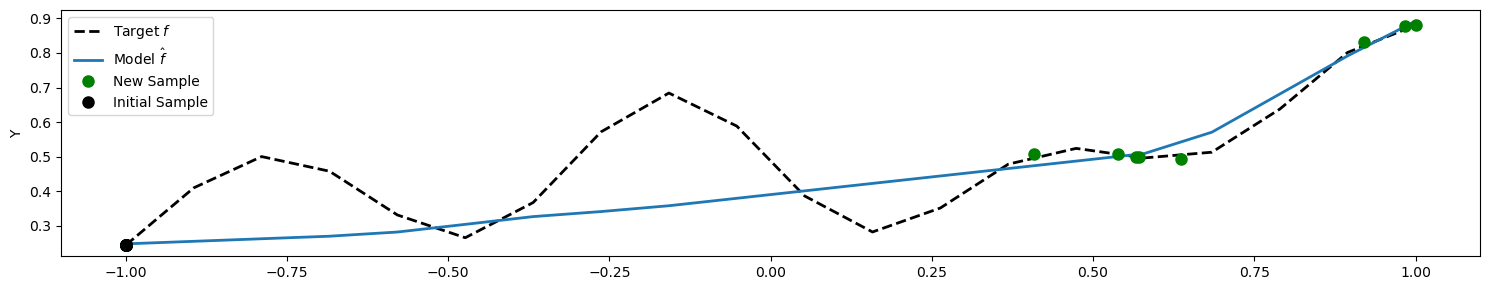

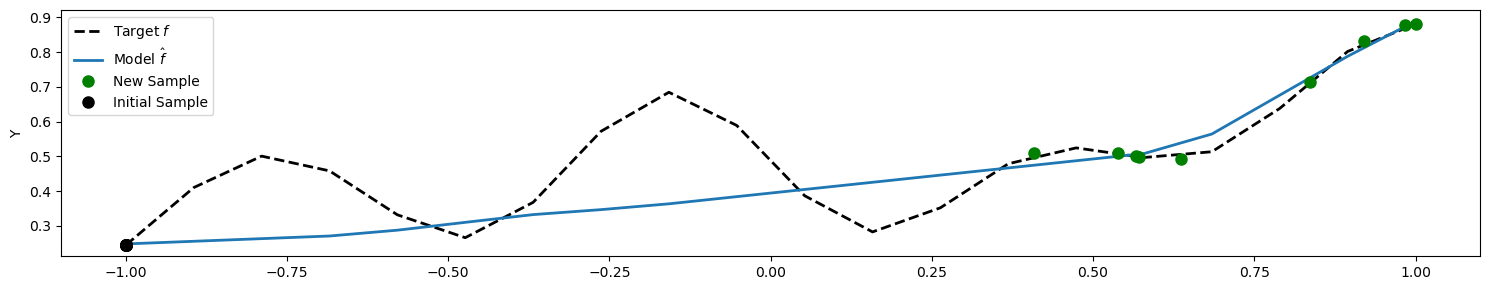

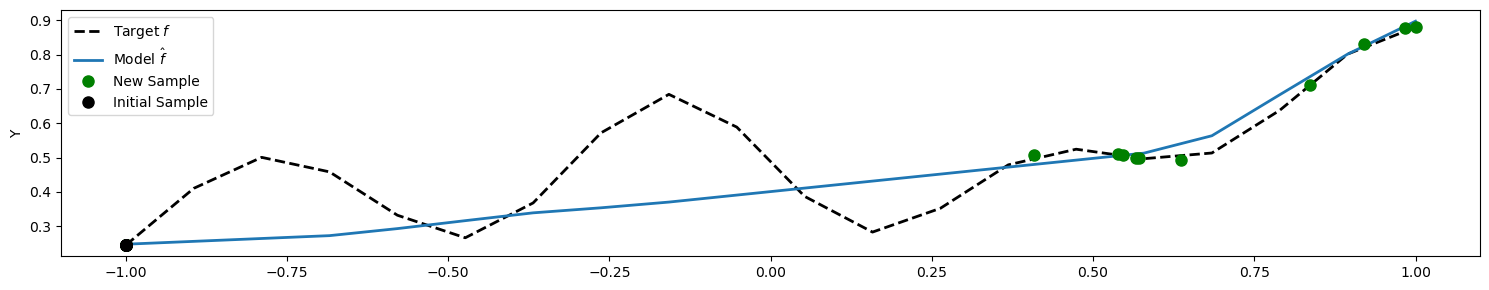

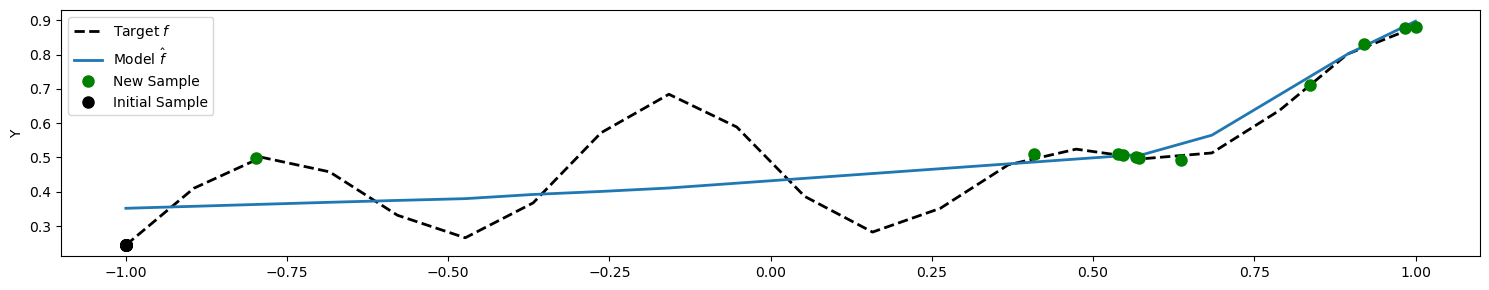

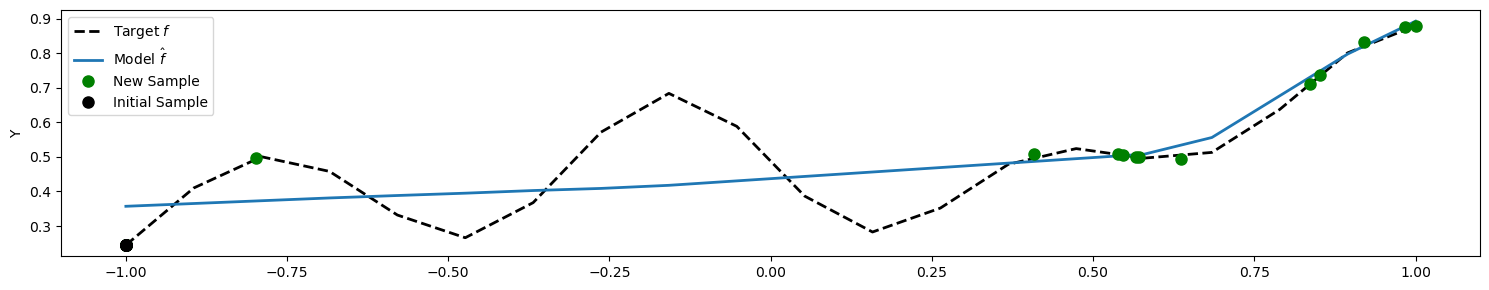

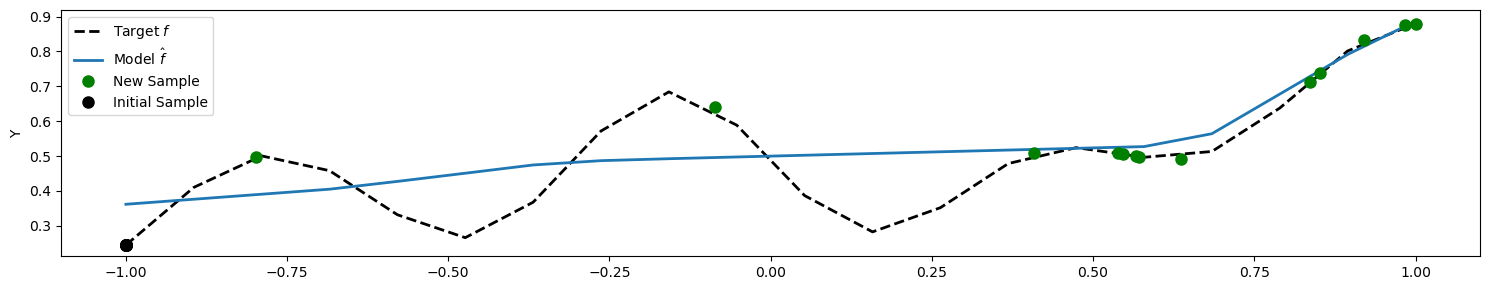

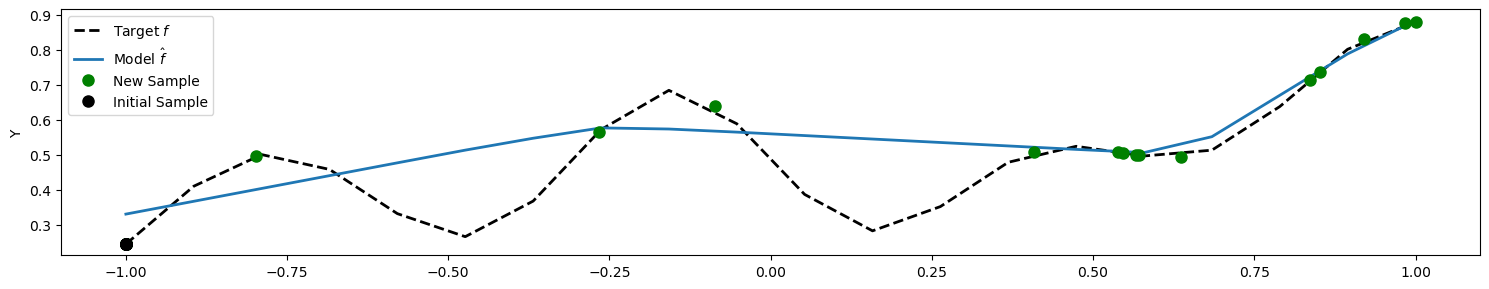

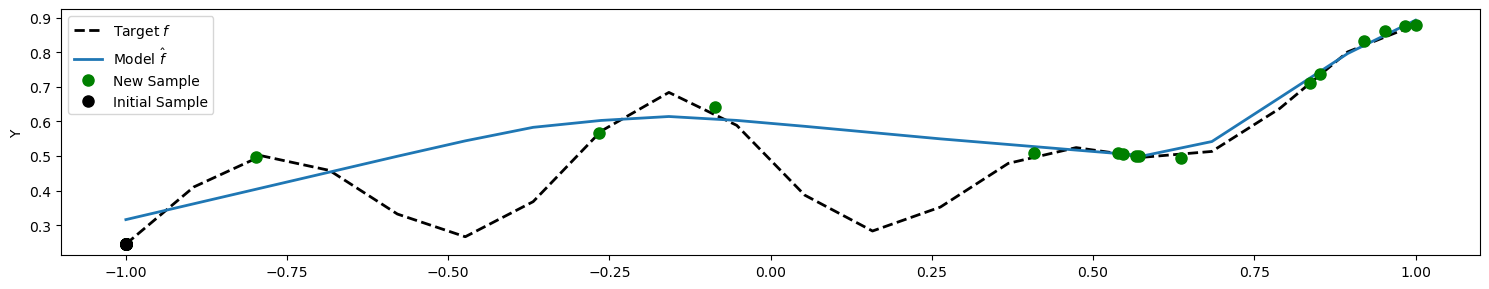

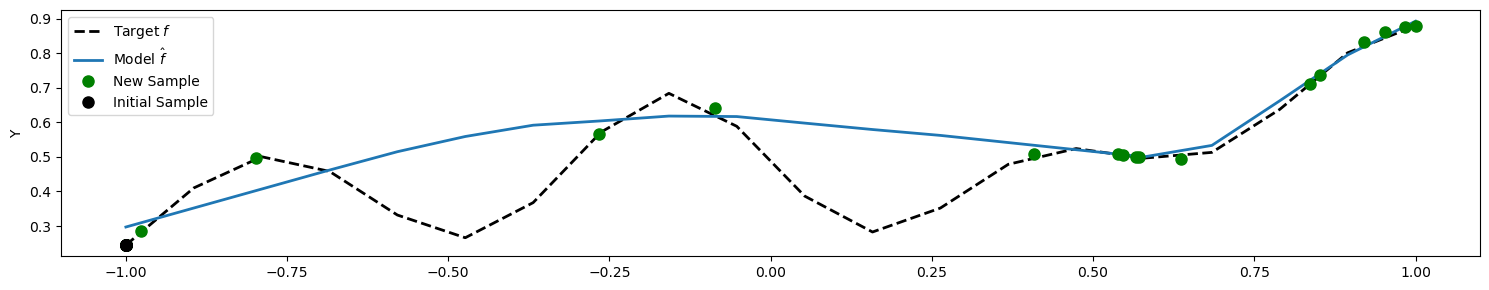

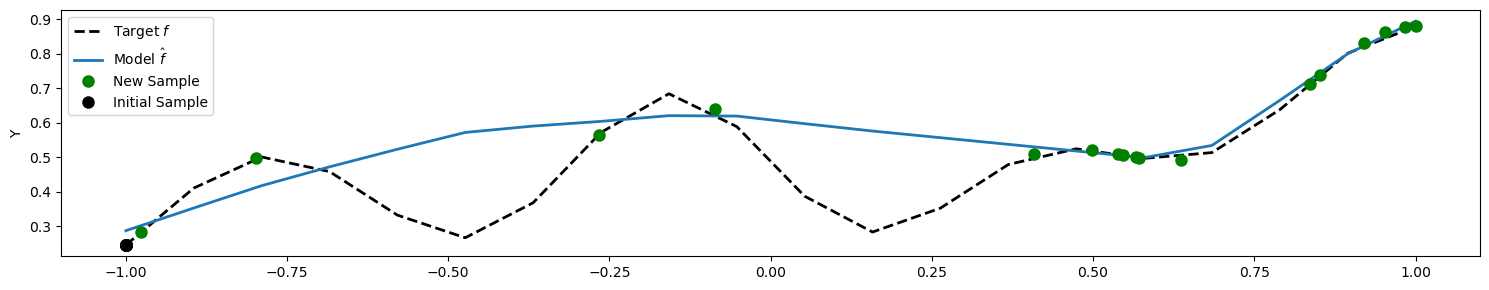

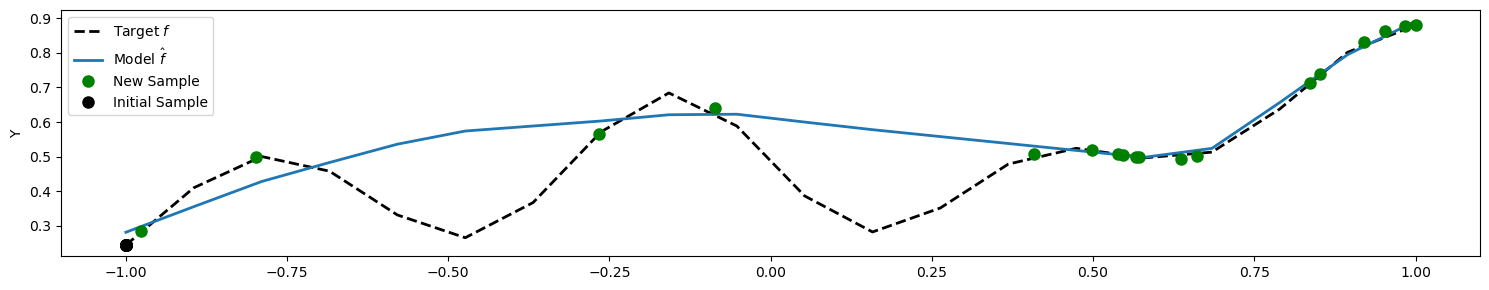

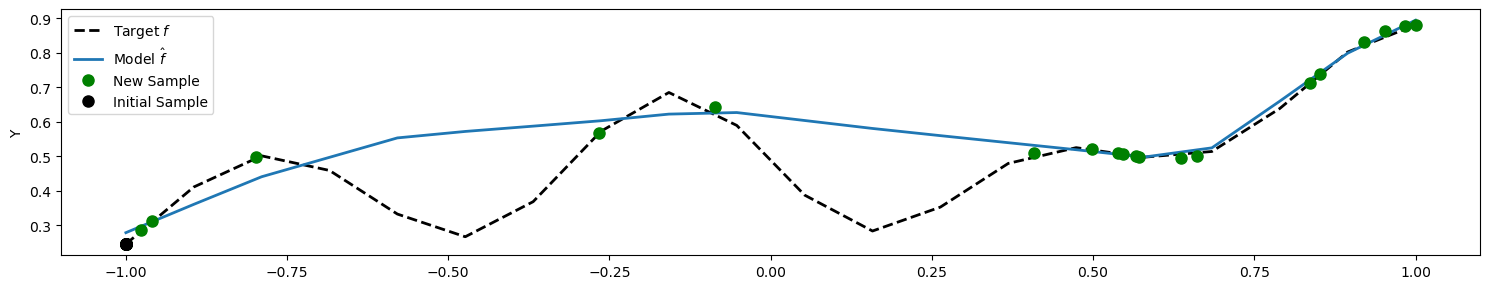

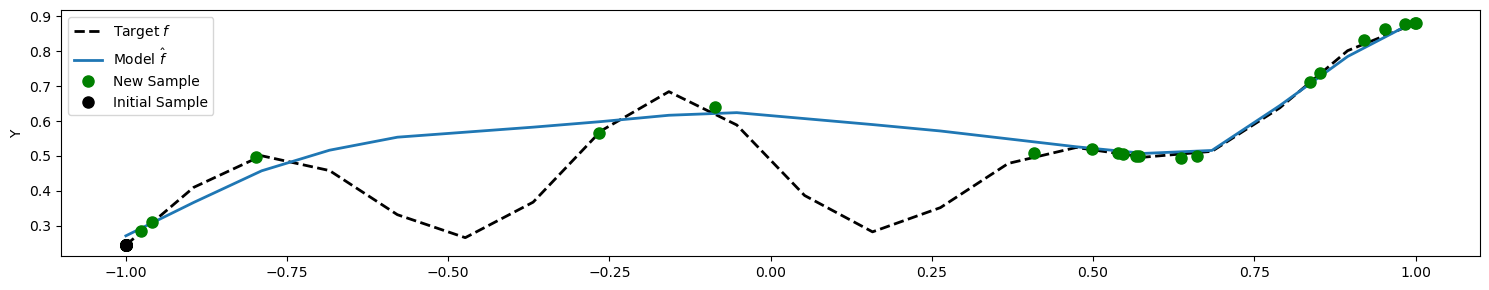

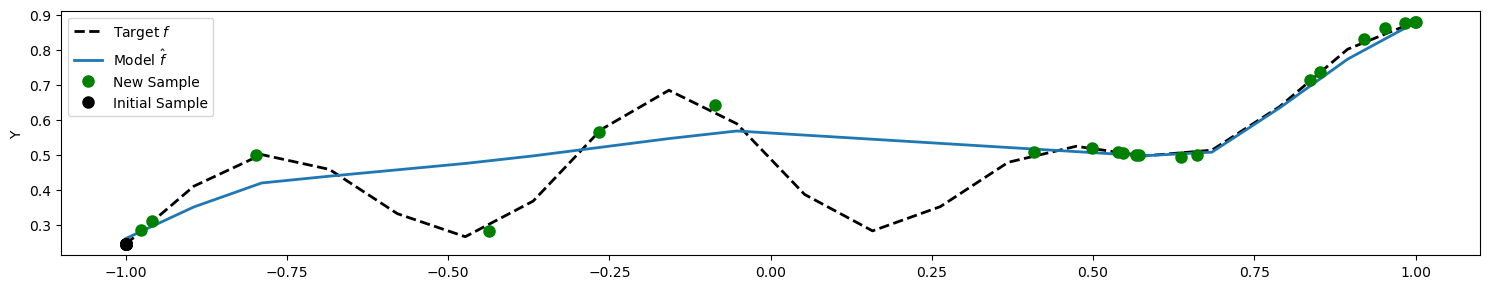

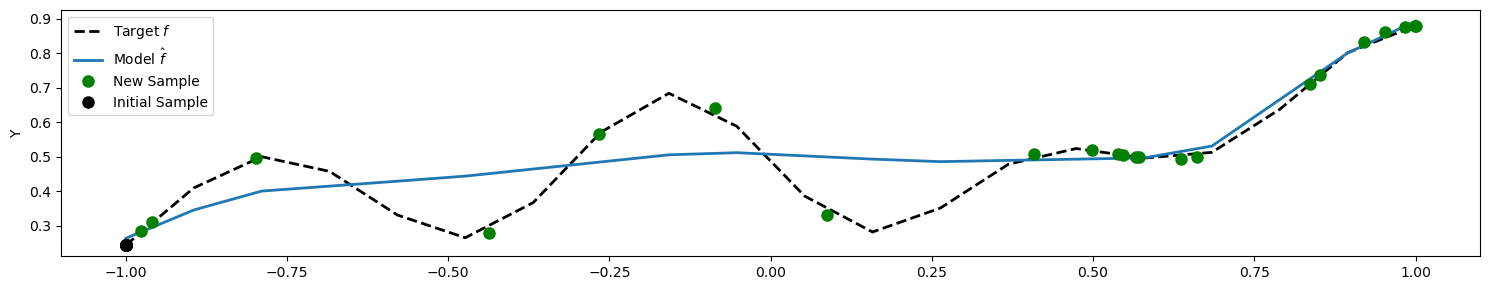

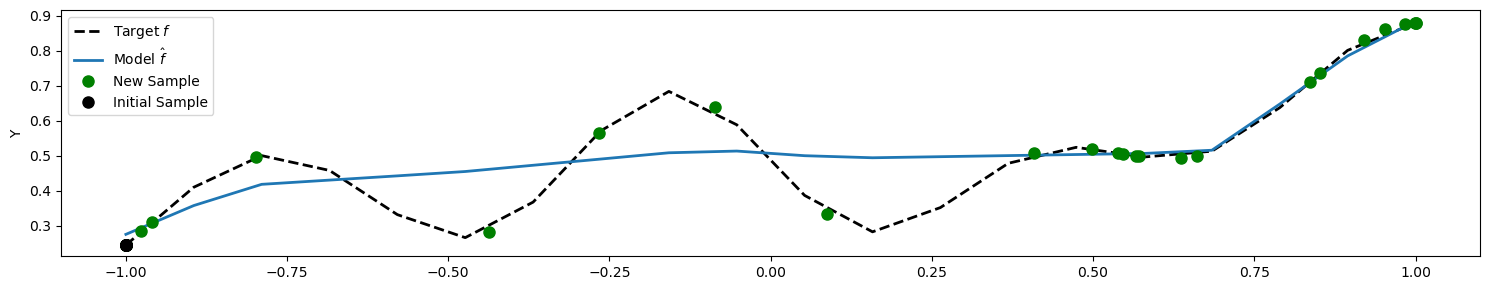

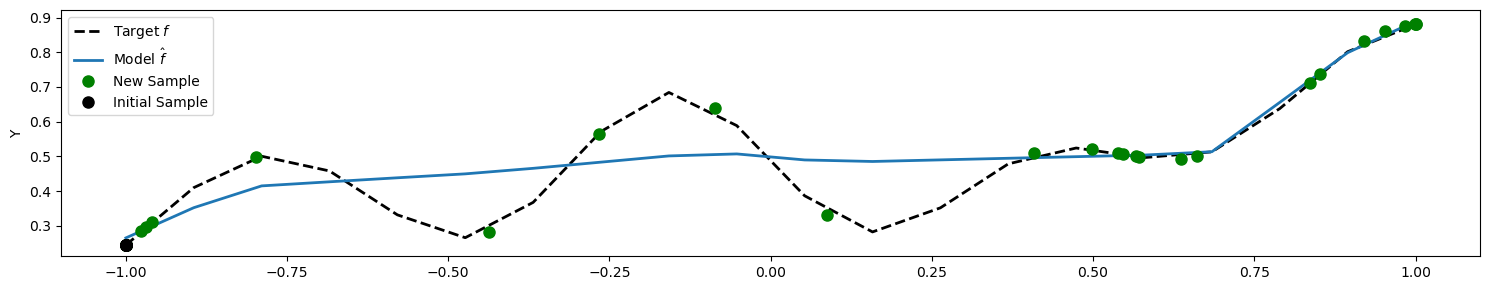

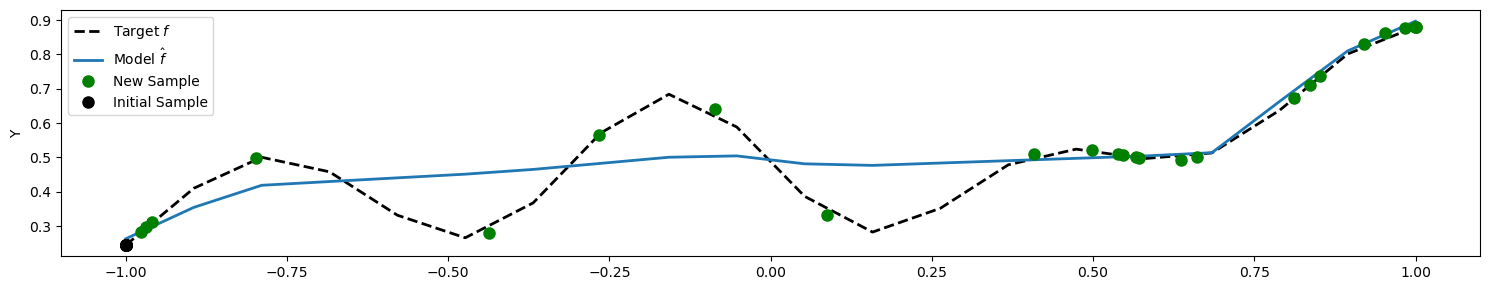

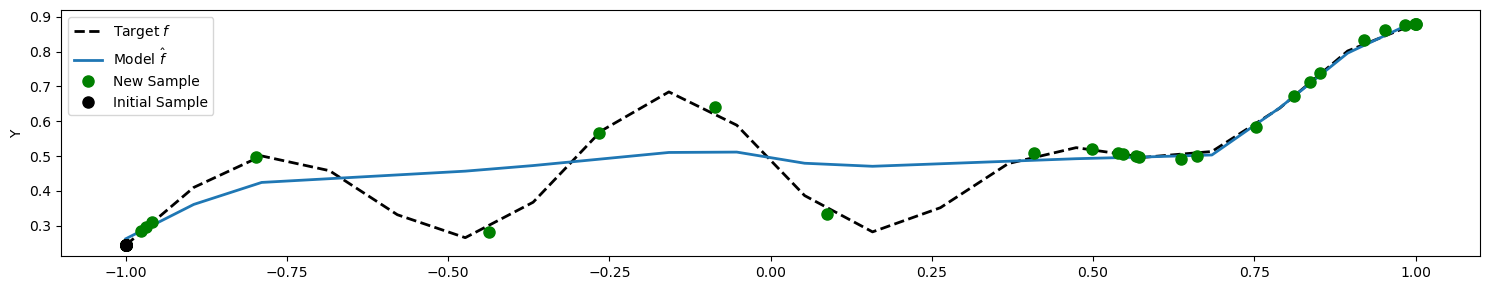

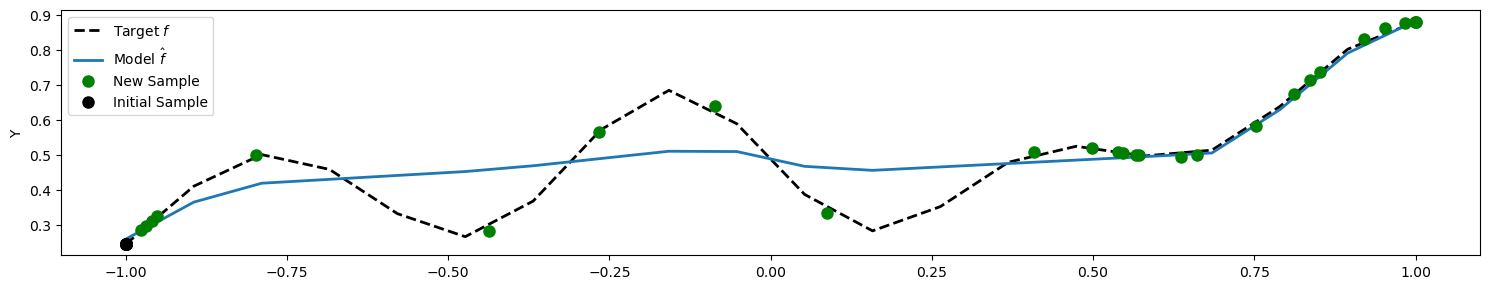

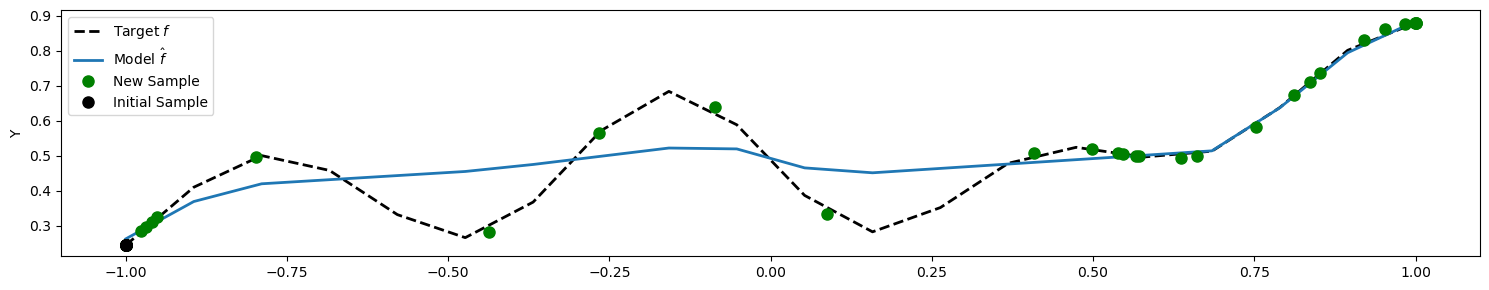

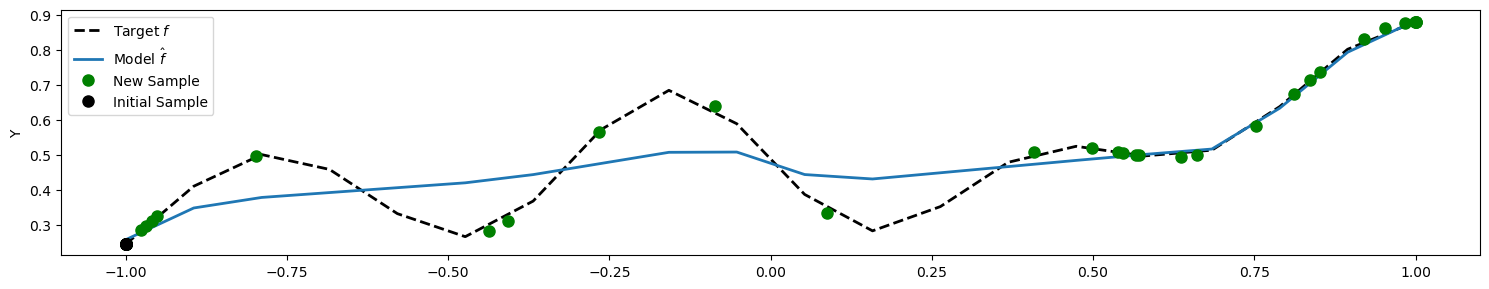

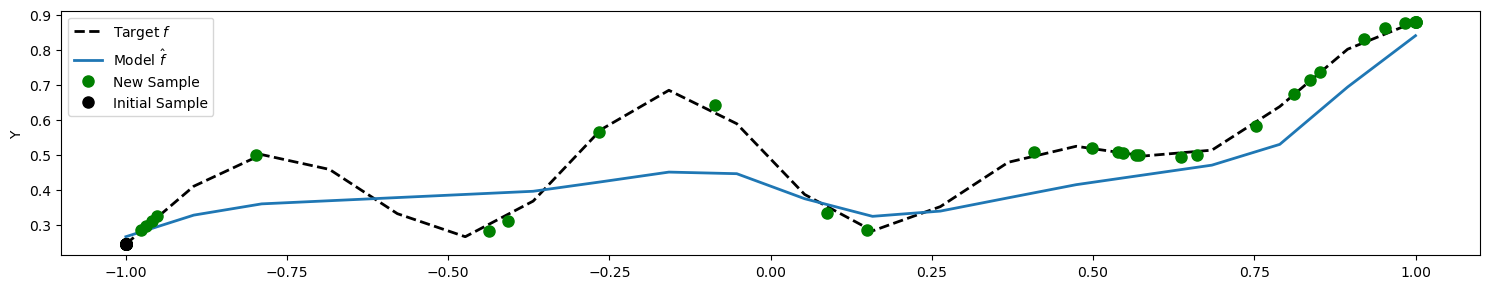

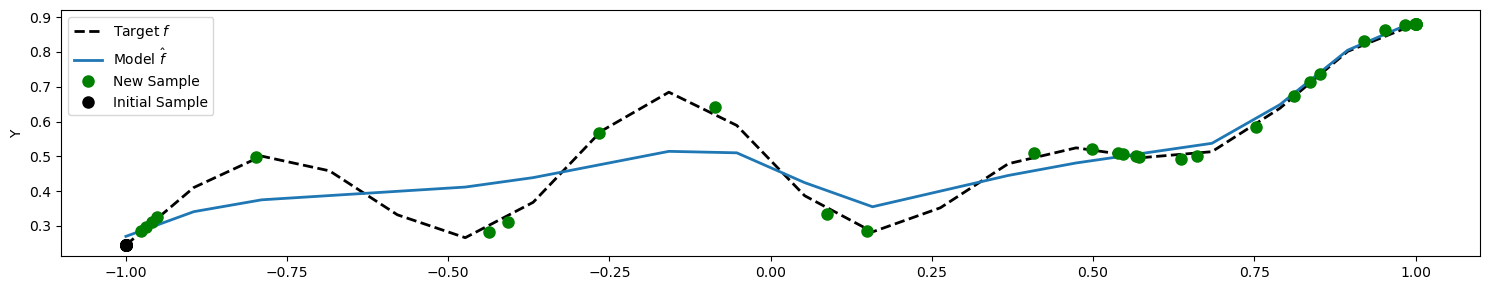

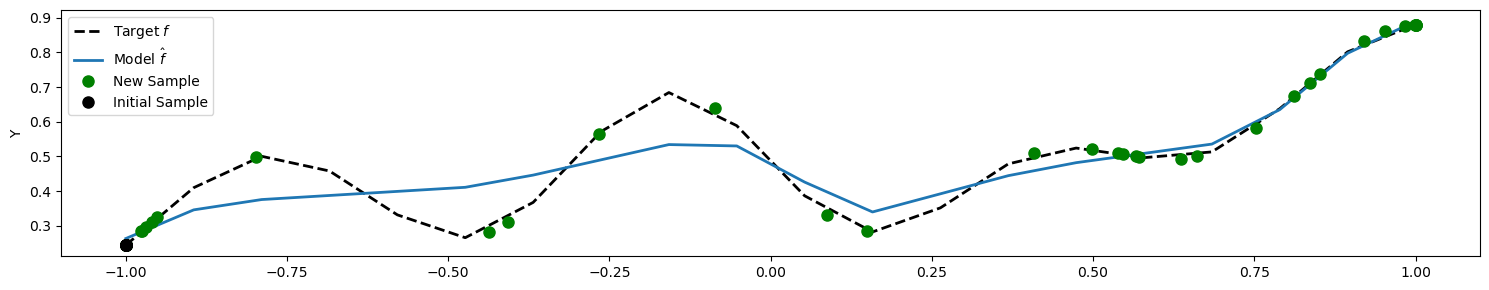

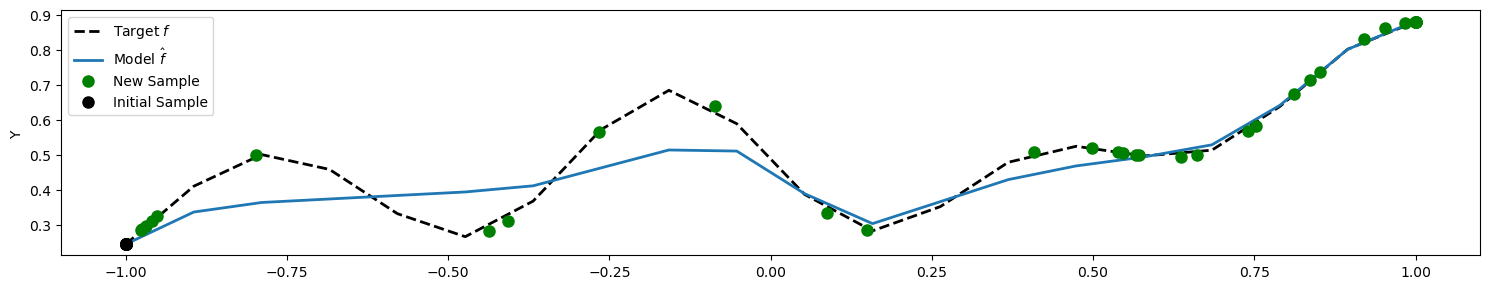

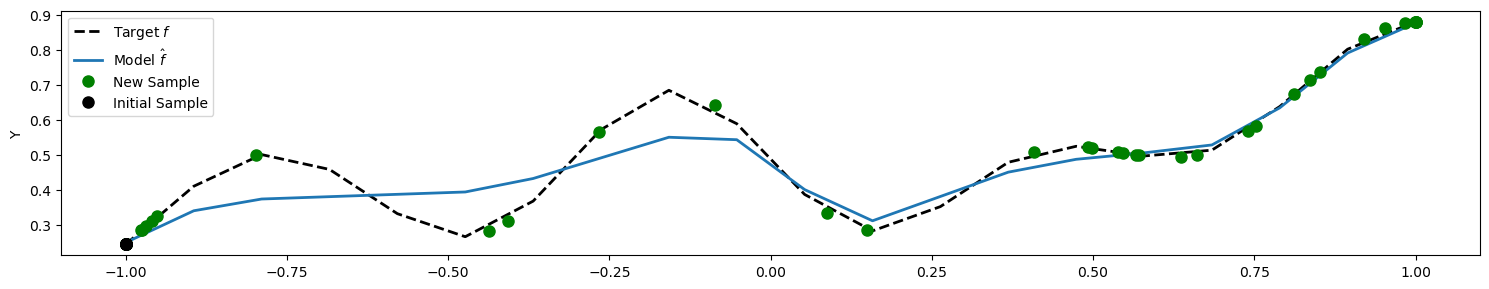

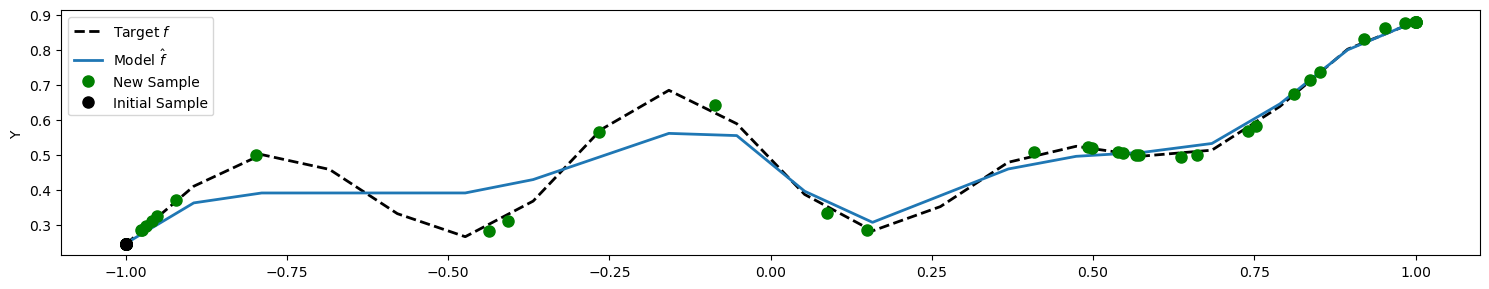

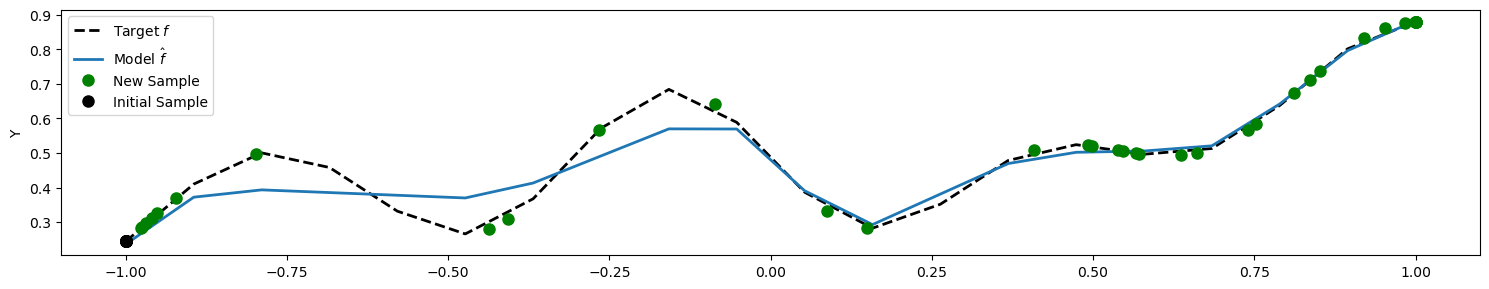

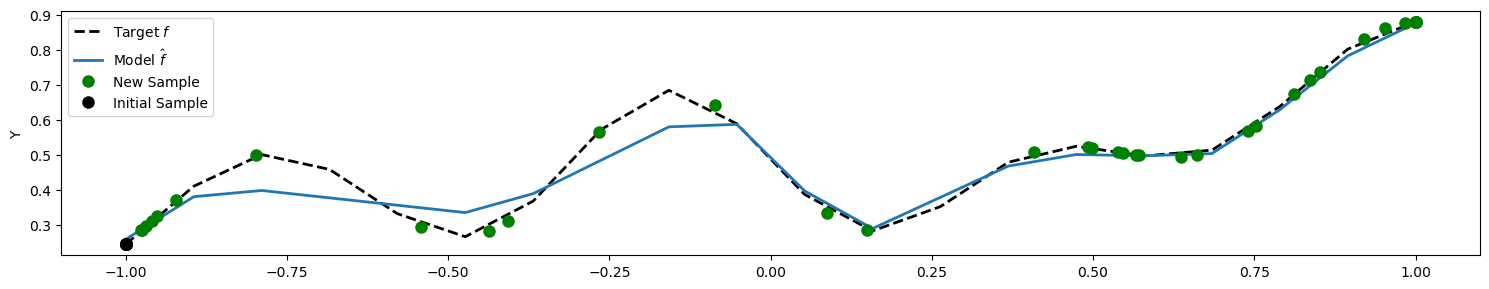

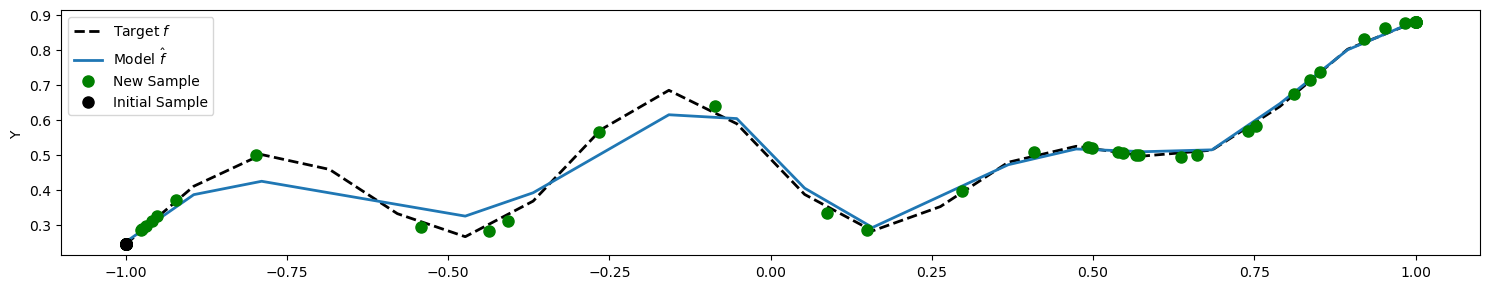

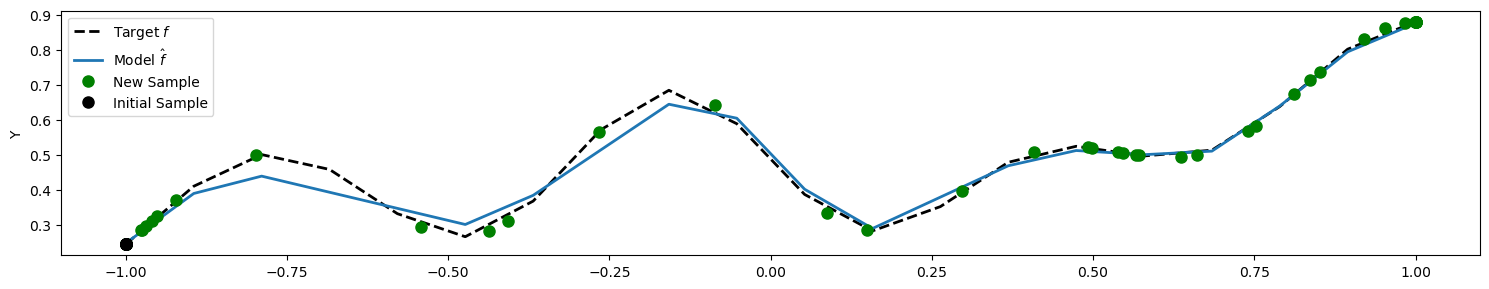

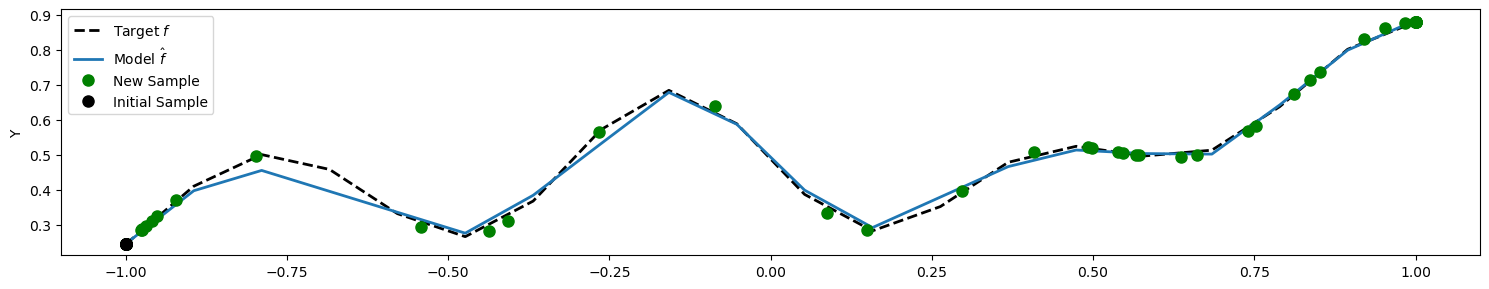

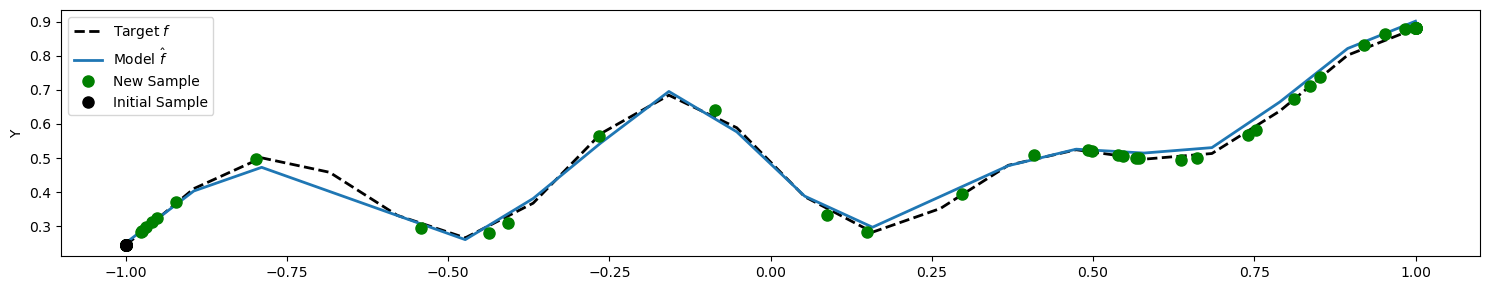

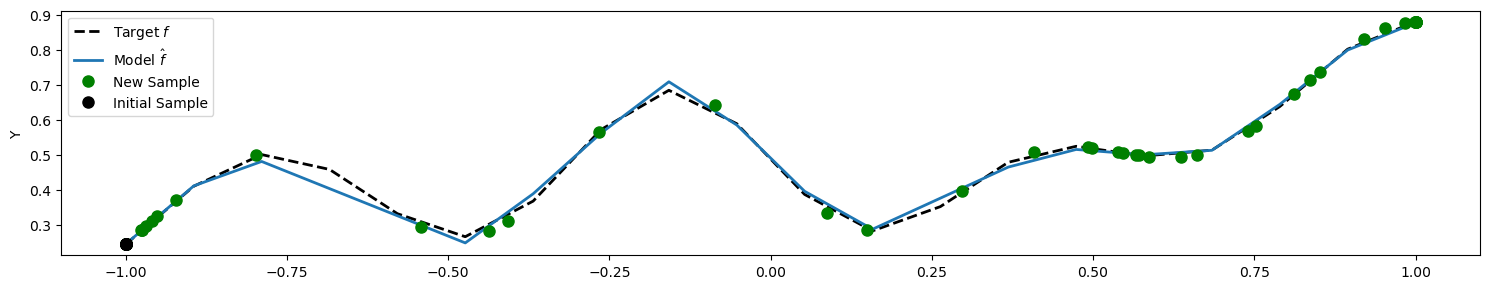

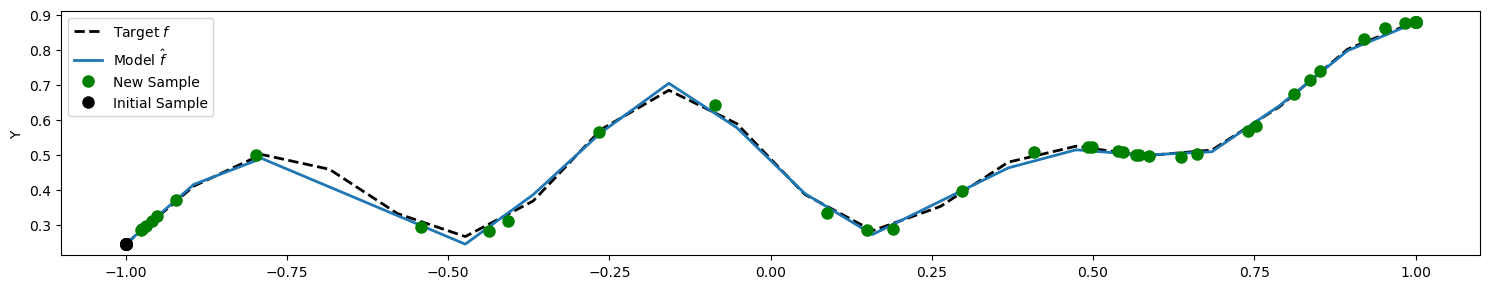

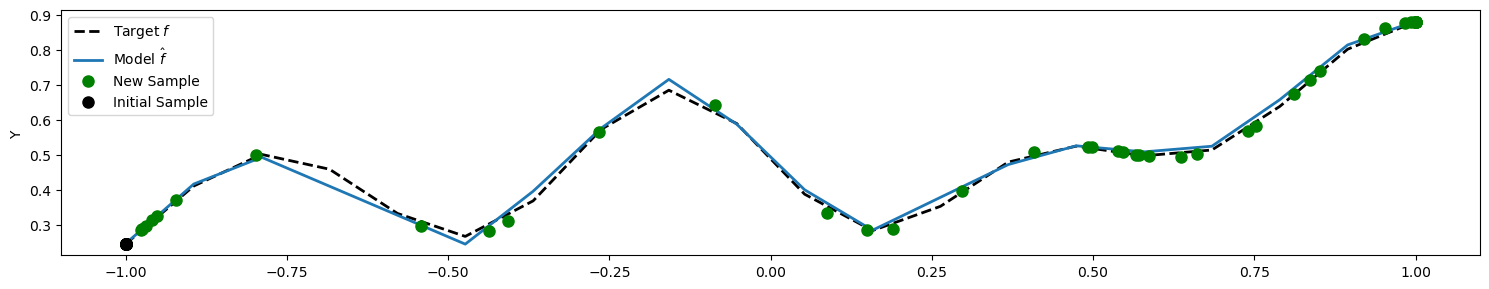

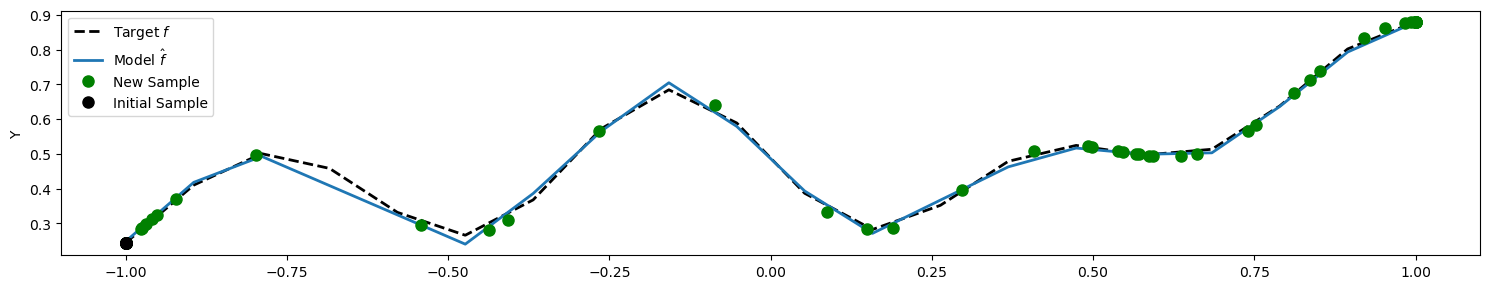

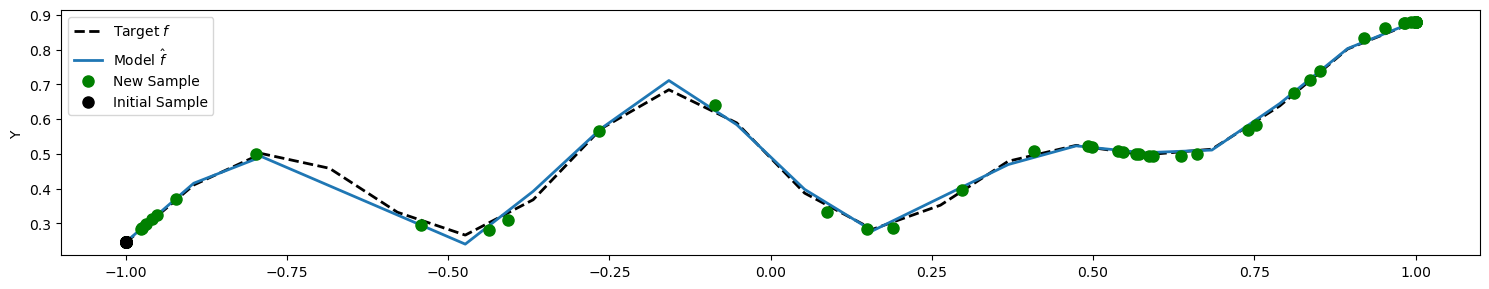

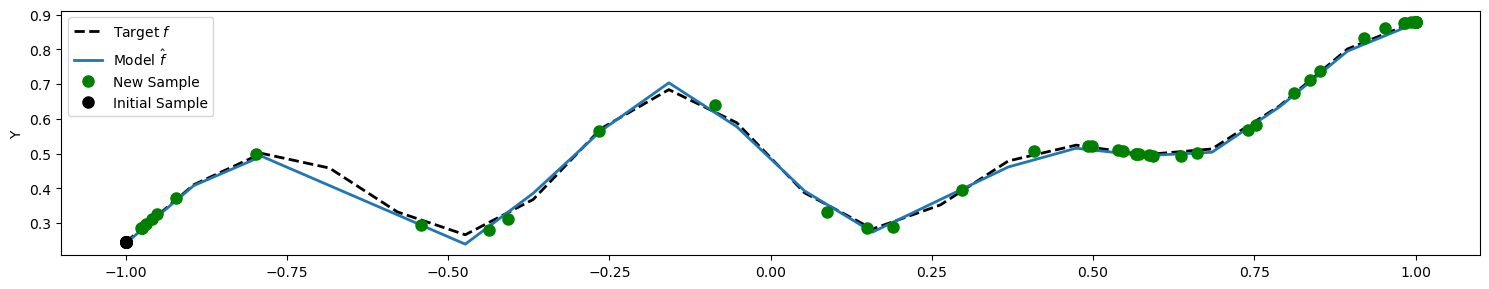

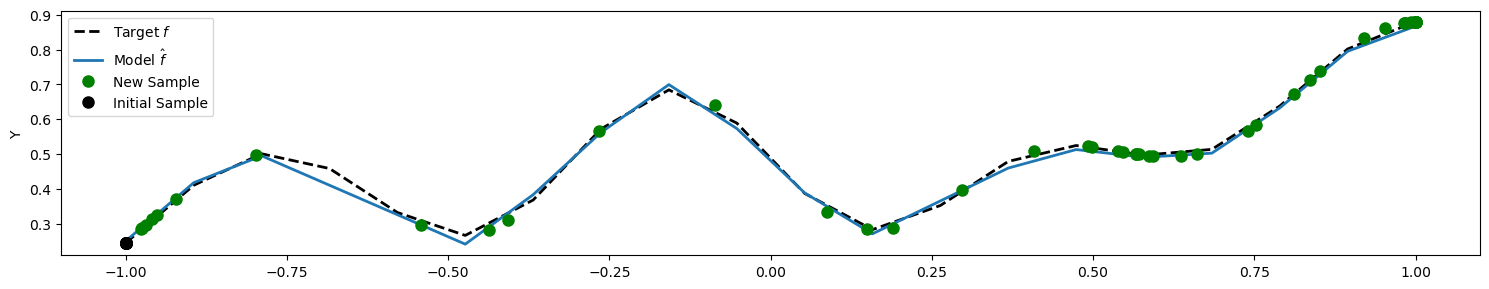

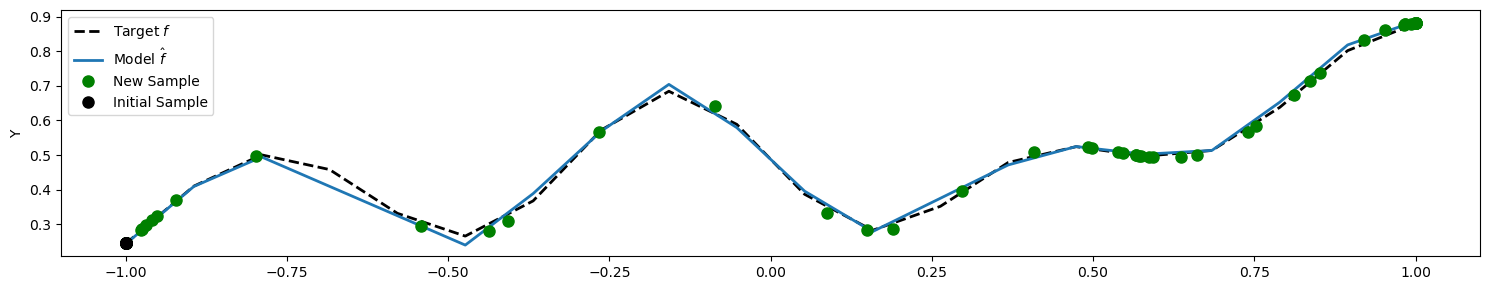

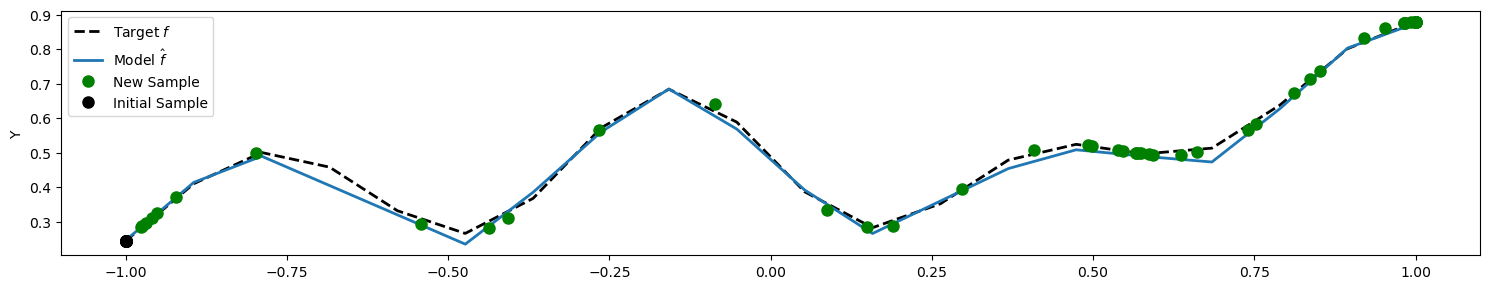

In [18]:
state = env.reset()
agent.is_training = False

for _ in range(50):
    action = agent.select_action(state)
    state, reward, done, info = env.step(action)
    env.toy_Plot(np.linspace(-1,1,20))